In [1]:
from os import makedirs
import pandas as pd
import plotly.express as px
from IPython.display import Image
from benchmarks.cli.data_loader import DEFAULT_DB_PATH, TBL

In [2]:
db_path = DEFAULT_DB_PATH  # SQL db path to read epoch stats from
tbl = TBL                  # SQL table name to read epoch stats from
out_dir = None             # Directory to save plot PNG/JSON to (e.g. "m3", "azl")
host = None                # Description of host the stats were collected on, used in plot subtitle (e.g. "M3 Mac", "Amazon Linux")

In [3]:
# Parameters
out_dir = "m3"


In [4]:
db_uri = f'sqlite:///{db_path}'
df = pd.read_sql_table(tbl, db_uri)
df

,start,epoch,n_rows,elapsed,gc,alb_start,sha,user,hostname,uri,fmt,batch_size,soma_chunk_size,py_buffer_size,soma_buffer_size
0,2024-05-30 23:27:49.212628,0,62312,3.119775,0.327354,2024-05-30 23:27:49.205469,c55d564310ca7225e24f07df56bdd3e350d0447c,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824
1,2024-05-30 23:32:57.453239,0,62312,3.076606,0.334267,2024-05-30 23:32:57.446944,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824
2,2024-05-30 23:33:01.014590,1,62312,2.827569,0.326742,2024-05-30 23:32:57.446944,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824
3,2024-05-30 23:33:04.223001,2,62312,2.769664,0.303220,2024-05-30 23:32:57.446944,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824
4,2024-05-30 23:33:07.352907,3,62312,2.903563,0.299384,2024-05-30 23:32:57.446944,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2024-05-30 23:55:19.211310,0,132766,15.452787,0.992820,2024-05-30 23:55:19.204935,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:7,scipy.csr,1024,16384,1073741824,1073741824
72,2024-05-30 23:55:37.078555,1,132766,15.100794,0.991398,2024-05-30 23:55:19.204935,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:7,scipy.csr,1024,16384,1073741824,1073741824
73,2024-05-30 23:55:54.412358,2,132766,15.351401,0.992165,2024-05-30 23:55:19.204935,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:7,scipy.csr,1024,16384,1073741824,1073741824
74,2024-05-30 23:56:11.809412,3,132766,15.567243,0.977199,2024-05-30 23:55:19.204935,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:7,scipy.csr,1024,16384,1073741824,1073741824


In [5]:
(df.elapsed > 0).value_counts()

True    76
Name: elapsed, dtype: int64

In [6]:
df.n_rows.value_counts()

132766    50
62312     26
Name: n_rows, dtype: int64

In [7]:
chunk_sizes = list(map(str, sorted(df['soma_chunk_size'].unique())))
x = 'SOMA chunk size'
y = 'Samples / sec'
df[x] = pd.Categorical(df['soma_chunk_size'].apply(str), categories=chunk_sizes)
df[y] = df.n_rows / df.elapsed
df

,start,epoch,n_rows,elapsed,gc,alb_start,sha,user,hostname,uri,fmt,batch_size,soma_chunk_size,py_buffer_size,soma_buffer_size,SOMA chunk size,Samples / sec
0,2024-05-30 23:27:49.212628,0,62312,3.119775,0.327354,2024-05-30 23:27:49.205469,c55d564310ca7225e24f07df56bdd3e350d0447c,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824,8192,19973.234885
1,2024-05-30 23:32:57.453239,0,62312,3.076606,0.334267,2024-05-30 23:32:57.446944,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824,8192,20253.486890
2,2024-05-30 23:33:01.014590,1,62312,2.827569,0.326742,2024-05-30 23:32:57.446944,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824,8192,22037.302917
3,2024-05-30 23:33:04.223001,2,62312,2.769664,0.303220,2024-05-30 23:32:57.446944,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824,8192,22498.035464
4,2024-05-30 23:33:07.352907,3,62312,2.903563,0.299384,2024-05-30 23:32:57.446944,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:4,np.array,1024,8192,1073741824,1073741824,8192,21460.529534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2024-05-30 23:55:19.211310,0,132766,15.452787,0.992820,2024-05-30 23:55:19.204935,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:7,scipy.csr,1024,16384,1073741824,1073741824,16384,8591.718806
72,2024-05-30 23:55:37.078555,1,132766,15.100794,0.991398,2024-05-30 23:55:19.204935,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:7,scipy.csr,1024,16384,1073741824,1073741824,16384,8791.987979
73,2024-05-30 23:55:54.412358,2,132766,15.351401,0.992165,2024-05-30 23:55:19.204935,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:7,scipy.csr,1024,16384,1073741824,1073741824,16384,8648.461415
74,2024-05-30 23:56:11.809412,3,132766,15.567243,0.977199,2024-05-30 23:55:19.204935,7aac3dee922c8365d6f7700991599ebc150bb725-dirty,ryan,ryan-tdb-m3.lan,data/census-benchmark_2:7,scipy.csr,1024,16384,1073741824,1073741824,16384,8528.549285


In [8]:
[hostname] = df.hostname.unique()
hostname

'ryan-tdb-m3.lan'

In [9]:
[batch_size] = df.batch_size.unique()
batch_size

1024

In [10]:
if host is None:
    if 'm3.lan' in hostname:
        host = 'M3 Mac'
    elif 'us-west-2' in hostname:
        host = 'Amazon Linux'
host_str = f"{host}, " if host else ""

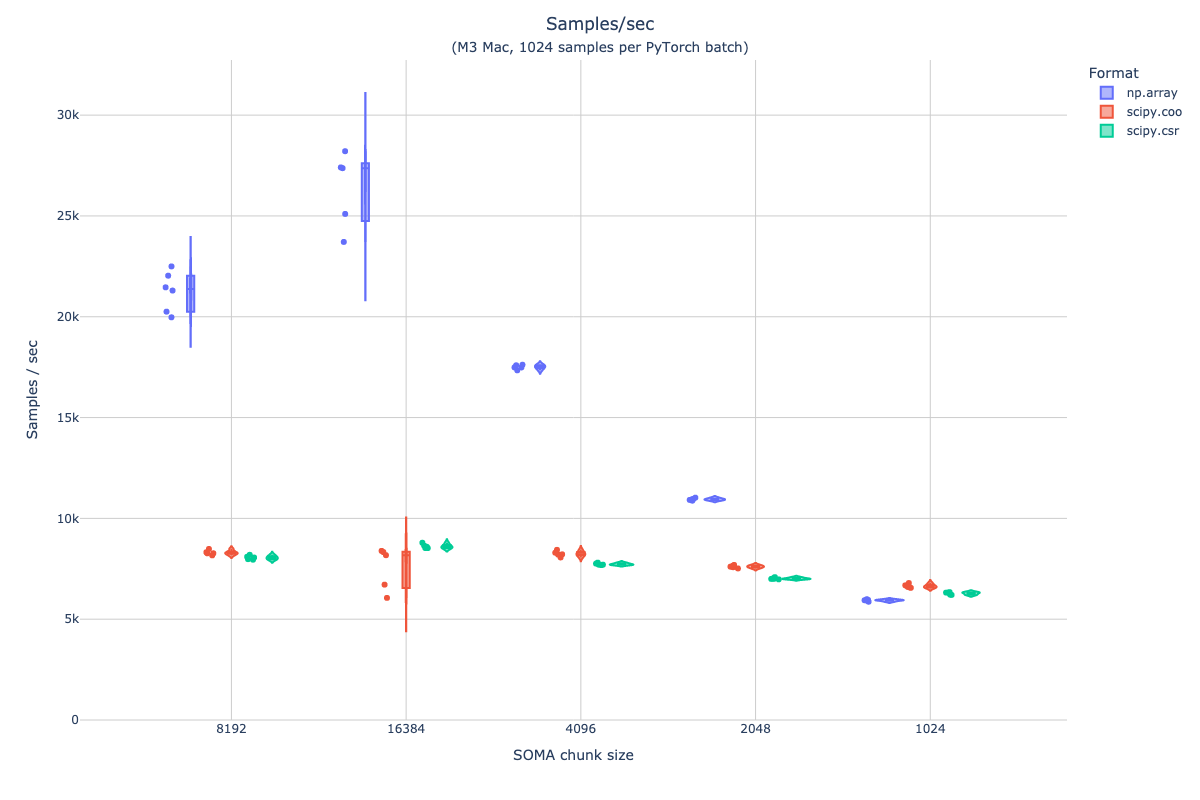

In [11]:
dims = dict(width=1200, height=800)
grid = '#ccc'
fig = px.violin(
    df, x=x, y=y,
    category_orders={ y: chunk_sizes, },
    color='fmt',
    box=True,
    points='all',
    labels={ 'fmt': "Format", }
).update_layout(
    plot_bgcolor='white',
    **dims,
    title=dict(
        text=f'Samples/sec<br><span style="font-size:0.8em">({host_str}{batch_size} samples per PyTorch batch)',
        x=0.5,
    )
).update_traces(
    hovertemplate=None,
).update_xaxes(
    gridcolor=grid,
).update_yaxes(
    gridcolor=grid,
    zeroline=True,
    zerolinecolor=grid,
    zerolinewidth=1,
    rangemode='tozero',
)
if out_dir:
    makedirs(out_dir, exist_ok=True)
    fig.write_image(f'{out_dir}/fig.png', **dims)
    fig.write_json(f'{out_dir}/fig.json')
Image(fig.to_image(**dims))